#  The normal model with pymc

##### Keywords: bayesian, normal-normal model, conjugate prior, MCMC engineering, pymc3

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt 
import seaborn as sns

from scipy.stats import norm


//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Contents
{:.no_toc}
* 
{: toc}

 A random variable $Y$ is normally distributed with mean $\mu$ and variance $\sigma^2$. Thus its density is given by :
 
 $$ p(y \vert \mu, \sigma^2) =  \frac{1}{ \sqrt{ 2 \pi \sigma^2}} e^{-( \frac{y-\mu}{2 \sigma})^2} $$
 
 
Suppose our model is $\{y_1, \ldots, y_n \vert \mu, \sigma^2 \} \sim N(\mu, \sigma^2)$ then
the likelihood is 

$$
p(y_1, \ldots, y_n \vert \mu, \sigma^2) = 
\prod_{i=1}^{n} p(y_i \vert \mu, \sigma^2)=\prod_{i=1}^{n}  \frac{1}{ \sqrt{ 2 \pi \sigma^2}} e^{-( \frac{(y_i-\mu)^2}{2\sigma^2})} = 
\frac{1}{ \sqrt{ 2 \pi \sigma^2}}   \exp \left\{  - \frac{1}{2}  \sum_i \frac{(y_i-\mu)^2}{\sigma^2} \right\} 
$$

We can now write the posterior for this model thus:

$$ p( \mu, \sigma^2 \vert  y_1, \ldots, y_n, \sigma^2)  \propto \frac{1}{ \sqrt{ 2 \pi \sigma^2}} e^{ - \frac{1}{2\sigma^2} \sum (y_i - \mu)^2 } \, p(\mu, \sigma^2)$$

Lets see the posterior of $\mu$ assuming we 
know $\sigma^2$.  

## Normal Model for fixed $\sigma$

Now we wish to condition on a known $\sigma^2$. The prior probability distribution for it can then be written as:

$$p(\sigma^2) = \delta(\sigma^2 -\sigma_0^2)$$

(which does integrate to 1).

Now, keeping in mind that $p(\mu, \sigma^2) = p(\mu \vert \sigma^2) p(\sigma^2)$ and carrying out the integral over $\sigma^2$ which because of the delta distribution means that we must just substitute $\sigma_0^2$ in, we get:

$$ p( \mu \vert  y_1, \ldots, y_n, \sigma^2 = \sigma_0^2)  \propto p(\mu \vert \sigma^2=\sigma_0^2) \,e^{ - \frac{1}{2\sigma_0^2} \sum (y_i - \mu)^2 }$$

where I have dropped the $\frac{1}{\sqrt{2\pi\sigma_0^2}}$ factor as there is no stochasticity in it (its fixed).


Say we have the prior

$$ p(\mu \vert \sigma^2) = \exp \left\{ -\frac{1}{2 \tau^2} (\hat{\mu}-\mu)^2 \right\} $$

then it can be shown that the posterior is 

$$  p( \mu \vert  y_1, \ldots, y_n, \sigma^2) \propto \exp \left\{ -\frac{a}{2} (\mu-b/a)^2 \right\} $$
where 
$$ a = \frac{1}{\tau^2} + \frac{n}{\sigma_0^2} , \;\;\;\;\; b = \frac{\hat{\mu}}{\tau^2} + \frac{\sum y_i}{\sigma_0^2} $$
This is a normal density curve with $1/\sqrt{a}$ playing the role of the 
standard deviation and $b/a$ playing the role of the mean. Re-writing this, 

$$ p( \mu \vert  y_1, \ldots, y_n, \sigma^2)  \propto \exp\left\{ -\frac{1}{2} \left( \frac{\mu-b/a}{1/\sqrt(a)}\right)^2 \right\} $$

**The conjugate of the normal is the normal itself**. 

Define $\kappa = \sigma^2 / \tau^2 $ to be the variance of the sample model  in units of variance
of our prior belief (prior distribution) then the *posterior mean* is 

$$\mu_p = \frac{b}{a} = \frac{ \kappa}{\kappa + n }  \hat{\mu} + \frac{n}{\kappa + n} \bar{y} $$

which is a weighted average of prior mean and sampling mean.
The variance is 

$$ \sigma_p^2 = \frac{1}{1/\tau^2+n/\sigma^2} $$
or better 

$$ \frac{1}{\sigma_p^2} = \frac{1}{\tau^2} + \frac{n}{\sigma^2}. $$

You can see that as $n$ increases, the data dominates the prior and the posterior mean approaches the data mean, with the posterior distribution narrowing...

## Example of the normal model for fixed $\sigma$

We have data on the wing length in millimeters of a nine members of a particular species of moth. We wish to make inferences from those measurements on the population mean $\mu$. Other studies show the wing length to be around 19 mm. We also know that the length must be positive. We can choose a prior that is normal and most of the density is above zero ($\mu=19.5,\tau=10$). This is only a **marginally informative** prior.

Many bayesians would prefer you choose relatively uninformative (and thus weakly regularizing) priors. This keeps the posterior in-line (it really does help a sampler remain in important regions), but does not add too much information into the problem.

The measurements were: 16.4, 17.0, 17.2, 17.4, 18.2, 18.2, 18.2, 19.9, 20.8 giving $\bar{y}=18.14$. 

In [2]:
Y = [16.4, 17.0, 17.2, 17.4, 18.2, 18.2, 18.2, 19.9, 20.8]
#Data Quantities
sig = np.std(Y) # assume that is the value of KNOWN sigma (in the likelihood)
mu_data = np.mean(Y)
n = len(Y)
print("sigma", sig, "mu", mu_data, "n", n)

sigma 1.33092374864 mu 18.1444444444 n 9


In [3]:
# Prior mean
mu_prior = 19.5
# prior std
tau = 10 

In [4]:
kappa = sig**2 / tau**2
sig_post =np.sqrt(1./( 1./tau**2 + n/sig**2));
# posterior mean
mu_post = kappa / (kappa + n) *mu_prior + n/(kappa+n)* mu_data
print("mu post", mu_post, "sig_post", sig_post)

mu post 18.1471071751 sig_post 0.443205311006


In [5]:
#samples
N = 18000
theta_prior = np.random.normal(loc=mu_prior, scale=tau, size=N);
theta_post = np.random.normal(loc=mu_post, scale=sig_post, size=N);

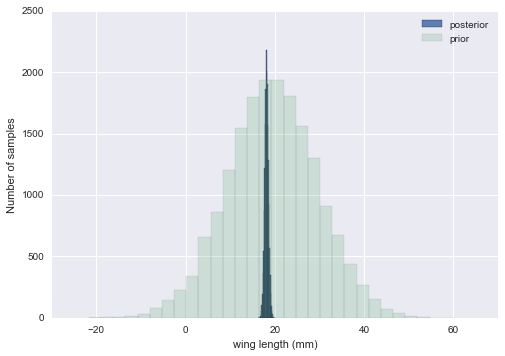

In [6]:
plt.hist(theta_post, bins=30, alpha=0.9, label="posterior");
plt.hist(theta_prior, bins=30, alpha=0.2, label="prior");
#plt.xlim([10, 30])
plt.xlabel("wing length (mm)")
plt.ylabel("Number of samples")
plt.legend();

## Sampling by  code

We now set up code to do metropolis using logs of distributions:

In [7]:
def metropolis(logp, qdraw, stepsize, nsamp, xinit):
    samples=np.empty(nsamp)
    x_prev = xinit
    accepted = 0
    for i in range(nsamp):
        x_star = qdraw(x_prev, stepsize)
        logp_star = logp(x_star)
        logp_prev = logp(x_prev)
        logpdfratio = logp_star -logp_prev
        u = np.random.uniform()
        if np.log(u) <= logpdfratio:
            samples[i] = x_star
            x_prev = x_star
            accepted += 1
        else:#we always get a sample
            samples[i]= x_prev
            
    return samples, accepted


In [8]:
def prop(x, step):
    return np.random.normal(x, step)

Remember, that up to normalization, the posterior is the likelihood times the prior. Thus the log of the posterior is the sum of the logs of the likelihood and the prior. 

In [9]:
logprior = lambda mu: norm.logpdf(mu, loc=19.5, scale=10)
loglike = lambda mu: np.sum(norm.logpdf(Y, loc=mu, scale=np.std(Y)))
logpost = lambda mu: loglike(mu) + logprior(mu)

Now we sample:

In [10]:
x0=np.random.uniform()
nsamps=100000
samps, acc = metropolis(logpost, prop, 1, nsamps, x0)

The acceptance rate is reasonable. You should shoot for somewhere between 20 and 50%.

In [13]:
acc/nsamps

0.46181

appropriately thinned, we lose any correlation..

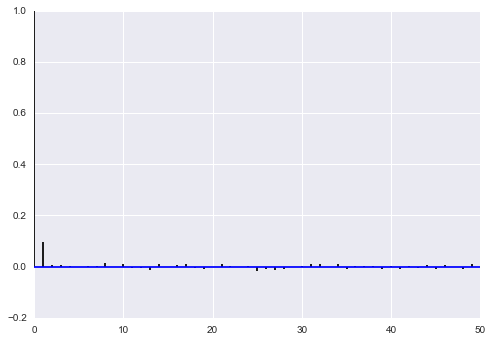

In [14]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])
corrplot(samps[10000::5]);

We compare kdeplots of the exact sampling to our MCMC result and find that we do well.

//anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


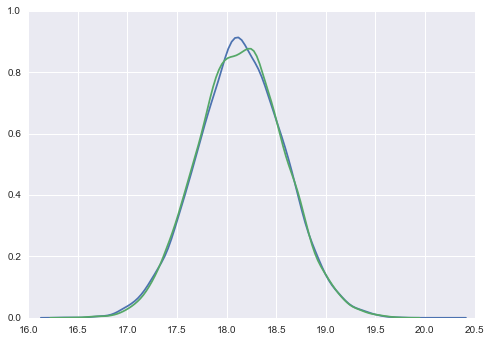

In [15]:
sns.kdeplot(theta_post);
sns.kdeplot(samps[10000::5]);

## Sampling with pymc

We'll use this simple example to show how to sample with pymc. To install pymc3, do

`conda install pymc3`.

For me this installed  `pymc3.0 rc4`.

Pymc3 is basically a sampler which uses NUTS for continuous variables and Metropolis for discrete ones, but we can force it to use Metropolis for all, which is what we shall do for now.

pymc3 docs are available [here](https://pymc-devs.github.io/pymc3/). 

The structure is that we define a model within a context manager, and optionally do the sampling there. The model name (`model1` below) and trace name (`model1trace` below) are both important names you should keep track of.

In [32]:
import pymc3 as pm
with pm.Model() as model1:
    mu = pm.Normal('mu', mu=19.5, sd=10)#parameter's prior
    wingspan = pm.Normal('wingspan', mu=mu, sd=np.std(Y), observed=Y)#likelihood
    stepper=pm.Metropolis()
    tracemodel1=pm.sample(100000, step=stepper)

100%|██████████| 100000/100000 [00:10<00:00, 9878.33it/s]| 528/100000 [00:00<00:18, 5279.00it/s]


Notice that `wingspan`, which is the  data, is defined using the same exact notation as the  prior abovem with the addition of the `observed` argument. This is because Bayesian notation does not distinguish between data d=and parameter nodes..everything is treated equally, and all the action is in taking conditionals and marginals of distributions.

Pymc3 gives us a nice summary of our trace

In [33]:
pm.summary(tracemodel1)


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  18.148           0.443            0.003            [17.285, 19.019]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  17.277         17.849         18.146         18.446         19.012



The highest-posterior-density  is the  smallest width interval containing a pre-specified density amount. Here the default is the smallest width containing 95% of the density. Such an interval is called a **Bayesian Credible Interval**.

In [34]:
pm.hpd(tracemodel1)#pm.hpd(tracemodel1, alpha=0.05)

{'mu': array([ 17.28546501,  19.01939789])}

You can also get quantiles:

In [35]:
pm.quantiles(tracemodel1)

{'mu': {2.5: 17.277302993852039,
  25: 17.849184635010953,
  50: 18.146408111329393,
  75: 18.446078420111572,
  97.5: 19.012211728353204}}

`pm.traceplot` will give you marginal posteriors and traces for all the "stochastics" in your model (ie non-data). It can even give you traces for some deterministic functions of stochastics..we shall see an example of this soon.

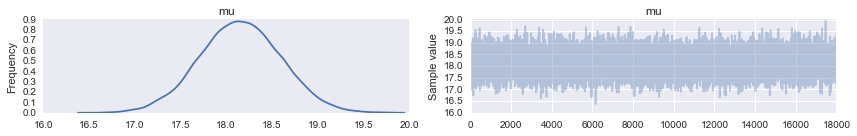

In [36]:
pm.traceplot(tracemodel1[10000::5]);

Autocorrelation is easily accessible as well.

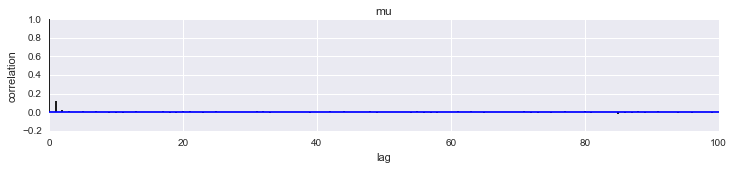

In [37]:
pm.autocorrplot(tracemodel1[10000::5]);

Here we plot the results of our sampling against the exact solution and out manual sampler and see that all three match well.

//anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


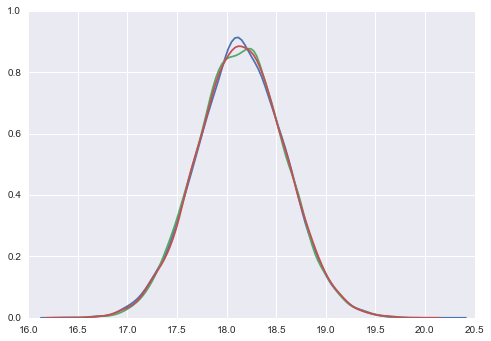

In [38]:
sns.kdeplot(theta_post);
sns.kdeplot(samps[10000::5]);
sns.kdeplot(tracemodel1[10000::5]['mu']);

The **posterior predictive** is accessed via the `sample_ppc` function, which takes the trace, the number of samples wanted, and the model as arguments. The sampler will use the posterior traces and the defined likelihood to return samples from the posterior predictive.

In [39]:
tr1 = tracemodel1[10000::5]
postpred = pm.sample_ppc(tr1, 1000, model1)

100%|██████████| 1000/1000 [00:01<00:00, 510.20it/s]   | 25/1000 [00:00<00:03, 244.20it/s]


The posterior predictive will return samples for all data in the model's  `observed_RVs`.

In [40]:
model1.observed_RVs

[wingspan]

In [41]:
postpred['wingspan'][:10]

array([[ 16.3937558 ],
       [ 17.2874764 ],
       [ 20.07861079],
       [ 19.9235275 ],
       [ 17.84781417],
       [ 17.41060809],
       [ 17.7077259 ],
       [ 17.83088555],
       [ 20.09129122],
       [ 19.43278128]])

We plot the posterior predictive against the posterior to see how it is spread out! When we compare the posterior predictive to the posterior (unlike in the beta-binomial distribution where one is a rate and one is a count, here both are on the same scale), we find that the posterior predictive is smeared out due to the additional uncertainty from the sampling distribution.

//anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


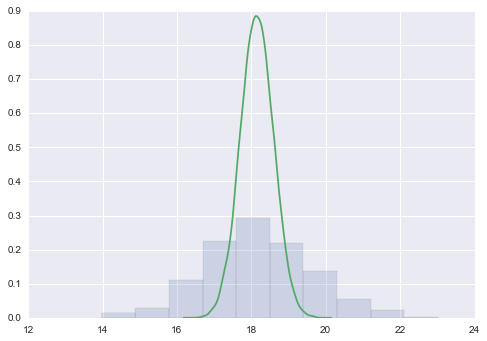

In [42]:
plt.hist(postpred['wingspan'], alpha=0.2, normed=True)
sns.kdeplot(tr1['mu']);